In [1]:
import warnings
warnings.filterwarnings("ignore")

# Point Pattern Analysis


In [2]:
%matplotlib inline

import numpy
import pandas
import geopandas
import pysal
import seaborn
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

## Introduction

Points are spatial entities that can be understood in two fundamentally different ways. On the one hand, points can be seen as fixed objects in space, which is to say their location is taken as given (*exogenous*). In this interpretation, the location of an observed point is considered as secondary to the value observed at the point. Think of this like measuring the number of cars traversing a given road intersection; the location is fixed, and the data of interest comes from the measurement taken at that location. The analysis of this kind of point data is very similar to that of other types of spatial data such as polygons and lines. On the other hand, an observation occurring at a point can also be thought of as a site of measurement from an underlying geographically-continuous process. In this case, the measurement could theoretically take place anywhere, but was only carried out or conducted in certain locations. Think of this as measuring the length of birds' wings: the location at which birds are measured reflects the underlying geographical process of bird movement and foraging, and the length of the birds' wings may reflect an underlying ecological process that varies by bird. This kind of approach means that both the location and the measurement matter. This is the perspective we will adopt in the rest of the chapter.

When points are seen as events that could take place in several locations but only happen in a few of them, a collection of such events is called a *point pattern*. In this case, the location of points is one of the key aspects of interest for analysis. A good example of a point pattern is geo-tagged photographs: they could technically happen in many locations but we usually find photos tend to concentrate only in a handful of them. Point patterns can be *marked*, if more attributes are provided with the location, or *unmarked*, if only the coordinates of where the event occurred are provided. Continuing the photo example, an unmarked pattern would result if only the location where are taken is used for analysis, while we would be speaking of a marked point pattern if other attributes, such as the time, camera model, or a "image quality score" was provided with the location.

Point pattern analysis is thus concerned with the visualisation, description, statistical characterization, and modelling of point patterns, trying to understand the generating process that gives rise and explains the observed data. Common questions in this domain include:

- *What does the pattern look like?* 
- *What is the nature of the distribution of points?* 
- *Is there any structure in the way locations are arranged over space? That is, are events clustered or dispersed?*
- *Why do events occur in those places and not in others?* 

At this point, it is useful to remind ourselves of an important distinction, that between process and pattern. The former relates to the underlying mechanism that is at work to generate the outcome we end up observing. Because of its abstract nature, we do not get to see it. However, in many contexts, the key focus of any analysis is to learn about *what* determines a given phenomenon and *how* those factors combine to generate it. In this context, "process" is associated with the *how*. "Pattern," on the other hand, relates to the result of that process. In some cases, it is the only trace of the process we can observe and thus the only input we have to work with in order to reconstruct it. Although directly observable and, arguably, easier to tackle, pattern is only a reflection of process. The real challenge is not to characterize the former but to use it to work out the latter.

In this chapter, we provide an introduction to point patterns through geo-tagged Flickr photos from Tokyo. We will treat the phenomena represented in the data as events: photos could be taken of any place in Tokyo, but only certain locations are captured. Keep in mind this understanding of Tokyo photos is not immutable: one could conceive cases where it makes sense to take those locations as given and look at the properties of each of them ignoring their "event" aspect. However, in this context, we will focus on those questions that relate to location and the collective shape of locations. The use of these tools will allow us to transform a long list of unintelligible XY coordinates into tangible phenomena with a characteristic spatial structure, and to answer questions about the center, dispersion, and clustering of attractions in Tokyo for Flickr users.



## The Tokyo photographs dataset

The rise of new forms of data such as geo-tagged photos uploaded to online services is creating new ways for researchers to study and understand cities. Where do people take pictures? When are those pictures taken? Why do certain places attract many more photographers than others? All these questions and more become more than just rhetorical ones when we consider, for example,  online photo hosting services as volunteered geographic information (VGI, {cite}`Goodchild2007citizens`). In this chapter we will explore metadata from a sample of geo-referenced images uploaded to [Flickr](https://www.flickr.com/) and extracted thanks to the [100m Flickr dataset](https://webscope.sandbox.yahoo.com/catalog.php?datatype=i&did=67). In doing so, we will introduce a few approaches that help us better understand the distribution and characteristics of a point pattern. 

To get started, let's load the Flickr data first:

In [3]:
db = pandas.read_csv('data/tokyo_clean.csv')

The table contains the following information about the sample of 10,000 photographs: the ID of the user who took the photo; the location expressed as latitude and longitude columns; a transformed version of those coordinates expressed in Pseudo Mercator; the timestamp when the photo was taken; and the URL where the picture they refer to is stored online:

In [4]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               10000 non-null  object 
 1   longitude             10000 non-null  float64
 2   latitude              10000 non-null  float64
 3   date_taken            10000 non-null  object 
 4   time_taken            10000 non-null  object 
 5   photo/video_page_url  10000 non-null  object 
 6   x                     10000 non-null  float64
 7   y                     10000 non-null  float64
dtypes: float64(4), object(4)
memory usage: 625.1+ KB


Note that the data is provided as a `.csv` file, so the spatial information is encoded as separate columns, one for each coordinate. This is contrast to how we have consumed spatial data in previous chapters, where spatial information was stored in a single column and encoded in geometry objects.


## Visualization


### Dots on a map

The first step to get a sense of what the spatial dimension of this dataset looks like is to plot it. At its most basic level, we can generate a scatter plot with `seaborn`:


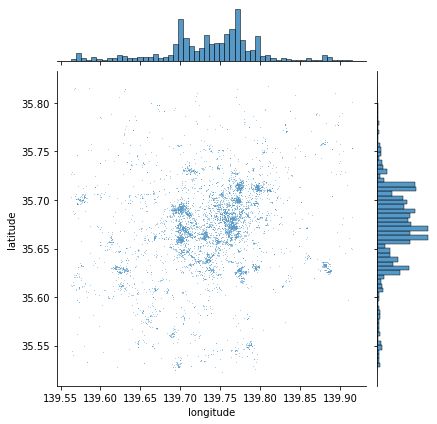

In [5]:
# Generate scatter plot
seaborn.jointplot(x='longitude', y='latitude', data=db, s=0.5);

This is a good start: we can see dots tend to be concentrated in the center of the covered area in a non-random pattern. Furthermore, within the broad pattern, we can also see there seems to be more localized clusters. However, the plot above has two key drawbacks: one, it lacks geographical context; and two, there are areas where the density of points is so large that it is hard to tell anything beyond a blue blurb. 

Start with the context. The easiest way to provide additional context is by overlaying a tile map from the internet. Let us quickly call `contextily` for that, and integrate it with `jointplot`:

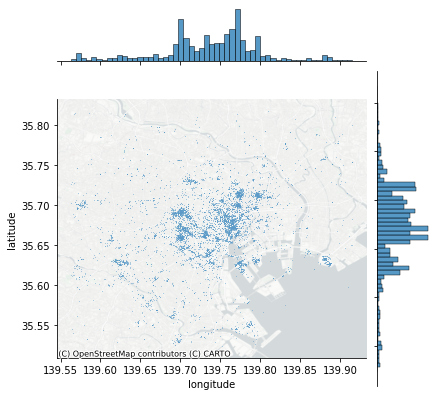

In [6]:
# Generate scatter plot
joint_axes = seaborn.jointplot(
    x='longitude', y='latitude', data=db, s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels
);

Note how we can pull out the axis where the points are plotted and add the basemap there, specifying the CRS as WGS84, since we are plotting longitude and latitude. Compared to the previous plot, adding a basemap to our initial plot makes the pattern of Flickr data clearer.

### Hex-binning

Consider our second problem: cluttering. When too many photos are concentrated in some areas of, plotting opaque dots on top of one another can make it hard to discern any pattern and explore its nature. For example, in the middle of the map, towards the right, there appears to be the highest concentration of pictures taken; the sheer amount of dots on the maps in some parts obscures whether all of that area receives as many pics or whether, within there, some places receive a particularly high degree of attention.

One solution to get around cluttering relates to what we referred to earlier as moving from {ref}`"tables to surfaces" <ch03-surfaces_as_tables>`. We can now recast this approach as a *spatial* or *2-dimensional histogram*. Here, we generate a regular grid (either squared or hexagonal), count how many dots fall within each grid cell, and present it as we would any other choropleth. This is attractive because it is simple, intuitive and, if fine enough, the regular grid removes some of the area distortions choropleth maps may induce. For this illustration, let us use use hexagonal binning (sometimes called hexbin) because it has slightly nicer properties than squared grids, such as less shape distortion and more regular connectivity between cells. Creating a hexbin 2-d histogram is straightforward in Python using the `hexbin` function:


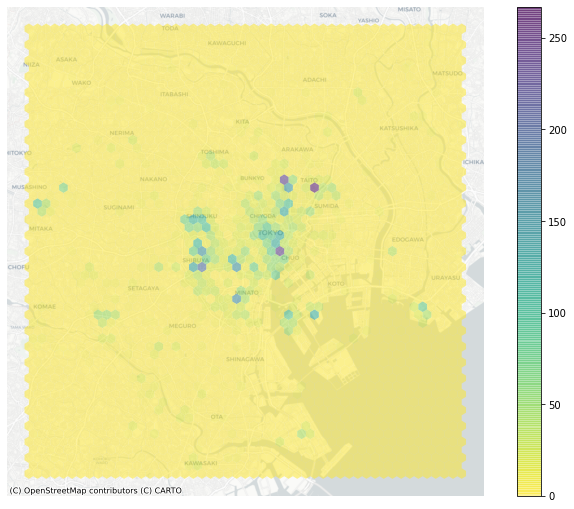

In [7]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each 
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    db['x'], 
    db['y'],
    gridsize=50, 
    linewidths=0,
    alpha=0.5, 
    cmap='viridis_r'
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

Voila, this allows a lot more detail! It is now clear that the majority of photographs relate to much more localized areas and that the previous map was obscuring this.

### Kernel Density Estimation (KDE)

Grids are the spatial equivalent of a histogram: the user decides how many "buckets", and the points are counted within them in a discrete fashion. This is fast, efficient, and potentially very detailed (if many bins are created). However, it does represent a discretization of an essentially contiguous phenomenon and, as such, it may introduce distortions. An alternative approach is to instead create what is known as a kernel density estimation (KDE): an empirical approximation of the probability density function. Instead of overlaying a grid of squares of hexagons and count how many points fall within each, a KDE lays a grid of points over the space of interest on which it places kernel functions that count points around them with different weight based on the distance. These counts are then aggregated to generate a global surface with probability. The most common kernel function is the Gaussian one, which applies a normal distribution to weight points. The result is a continuous surface with a probability function that may be evaluated at every point. Creating a Gaussian kernel in Python is rather straightforward:


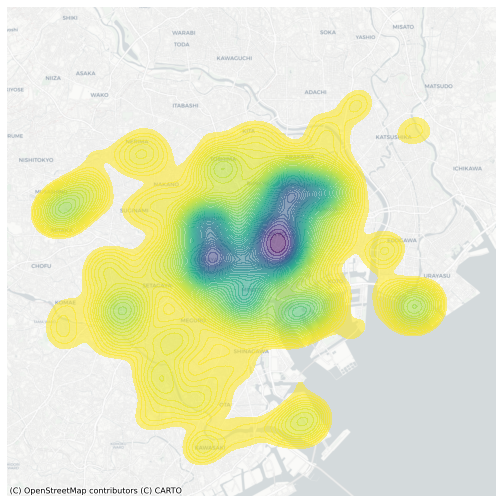

In [8]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients 
# coloured contours, 45% of transparency,
# and the reverse viridis colormap
seaborn.kdeplot(
    db['x'], 
    db['y'],
    n_levels=50, 
    shade=True,
    alpha=0.55, 
    cmap='viridis_r'
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()

The result is a smoother output that captures the same structure of the hexbin but "eases" the transitions between different areas. This provides a better generalization of the theoretical probability distribution over space.  Technically, the continuous nature of the KDE function implies that for any given point the probability of an event is 0. However, as the area around a point increases, the probability of an event within that area can be obtained.  This is useful in some cases, but is mainly of use to escape the restrictions imposed by a regular grid of hexagons or squares. 